In [0]:
import torch

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict
from torch import optim
from torchvision import datasets, transforms, models

In [0]:
# load the data from the folders
data_dir = 'data'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/val', transform=val_transforms)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64)


In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 3, 224, 224])
torch.Size([64])


In [0]:
def imshow(image, ax=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        # if the data loader has transform.normalize
        # undo preprocessing
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax

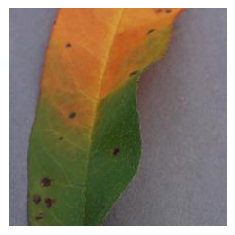

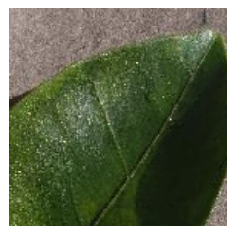

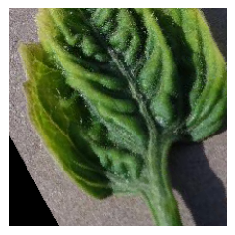

In [16]:
imshow(images[1]);
imshow(images[4]);
imshow(images[6]);

In [0]:
# use pretraned model
model = models.densenet201(pretrained=True)

/Users/rose/anaconda3/envs/agro/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

The above model was trained on imageNet which has 1000 different categories, For our model we have 38 categories.We will have to change the classifer

In [0]:
for param in model.parameters():
  param.required_grad = False

In [0]:
# change the classifier
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
              ('fc1', nn.Linear(1920, 500)),
              ('relu1', nn.ReLU()),
              ('dropout1', nn.Dropout(p=0.2)),
              ('fc2', nn.Linear(500, 256)),
              ('relu2', nn.ReLU()),
              ('dropout2', nn.Dropout(p=0.2)),
              ('fc3', nn.Linear(256, 38)),
              ('output', nn.LogSoftmax(dim=1))
              
]))
model.classifier = classifier

In [0]:
# Train either on GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
criterion = nn.NLLLoss()

optimizer = optim.SGD(model.classifier.parameters(), lr = 0.01, momentum=0.9)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
epochs = 10

for epoch in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        validation_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                
                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Valid Loss: {:.3f}.. ".format(validation_loss/len(val_loader)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(val_loader)))
        

In [0]:
# save model
torch.save({"state_dict":model.state_dict(),
           "class_to_idx":model.class_to_idx}, 'classifier.pth')

In [0]:
# load the model
def load_checkpoint(file_path):
    state_dict = torch.load(file_path, map_location="cpu")
    
    model = models.densenet201(pretrained=True)
    model.class_to_idx = state_dict["class_to_idx"]
    
    classifier = classifier = nn.Sequential(OrderedDict([
              ('fc1', nn.Linear(1920, 500)),
              ('relu1', nn.ReLU()),
              ('dropout1', nn.Dropout(p=0.2)),
              ('fc2', nn.Linear(500, 256)),
              ('relu2', nn.ReLU()),
              ('dropout2', nn.Dropout(p=0.2)),
              ('fc3', nn.Linear(256, 38)),
              ('output', nn.LogSoftmax(dim=1))
              
        ]))
    model.classifier = classifier
    
    for param in model.parameters():
        param.requires_grad = False
        
    model.load_state_dict(state_dict["state_dict"], strict=False)
    
    return model



In [5]:
# laod the model
model = load_checkpoint("classifier.pth")

/Users/rose/anaconda3/envs/agro/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
def process_image(image_path):
    
    test_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    from PIL import Image
    im = Image.open(image_path)
    im = test_transform(im)

    return im

In [0]:
def predict(image, model):
    # we have to process the image as we did while training the others
    image = process_image(image)
    
    image_input = image.unsqueeze(0)
    
    model.eval()
    outputs = model(image_input)
    ps = torch.exp(outputs)
    
    top_p, top_cls = ps.topk(5, dim=1)
    top_cls = top_cls.detach().numpy().tolist()[0]
    
    # covert indices to classes
    idx_to_class = {v: k for k, v in model.class_to_idx.items()}
    
    top_cls = [idx_to_class[top_class] for top_class in top_cls]
    
    return top_p, top_cls